### CIFAR10

In [ ]:
mnist = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# print(train_labels[0])
# plt.imshow(train_images[0], cmap='Greys_r')

train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255

train_labels = train_labels.reshape((-1))
test_labels = test_labels.reshape((-1))

data = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels.astype(np.int32)))
data = data.shuffle(buffer_size=50000).batch(128).repeat()

# note: we batch the test data, but do not shuffle/repeat
test_data = tf.data.Dataset.from_tensor_slices(
    (test_images, test_labels.astype(np.int32))).batch(128)

In [ ]:
model2 = tf.keras.Sequential(name="Model2")
model2.add(tf.keras.layers.Conv2D(32, 1, activation='relu', input_shape=(32,32,3)))
model2.add(tf.keras.layers.Conv2D(32, 1, activation='relu'))
model2.add(tf.keras.layers.MaxPool2D((2, 2)))

model2.add(tf.keras.layers.Conv2D(64, 1, activation='relu'))
model2.add(tf.keras.layers.Conv2D(64, 1, activation='relu'))
model2.add(tf.keras.layers.MaxPool2D((2, 2)))

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(100, activation='relu'))
model2.add(tf.keras.layers.Dense(10))
model2.summary()

Model: "Model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 32, 32, 32)        1056      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 16, 16, 64)        2112      
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 16, 16, 64)        4160      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 4096)              0    

In [ ]:
opt = tf.optimizers.Adam(0.01)

# from_logits = True!! #neverforget
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [ ]:
model2.compile(loss= loss_fn, optimizer= opt, metrics= ['accuracy'])
history = model2.fit(data, batch_size=64, epochs=5, steps_per_epoch=500)

test_scores = model2.evaluate(test_data, verbose= 2)

Epoch 1/5
500/500 [==============================] - 75s 151ms/step - loss: 0.8911 - accuracy: 0.6844
Epoch 2/5
500/500 [==============================] - 76s 152ms/step - loss: 0.8910 - accuracy: 0.6823
Epoch 3/5
500/500 [==============================] - 76s 153ms/step - loss: 0.8865 - accuracy: 0.6849
Epoch 4/5
500/500 [==============================] - 78s 157ms/step - loss: 0.8798 - accuracy: 0.6884
Epoch 5/5
500/500 [==============================] - 76s 152ms/step - loss: 0.8644 - accuracy: 0.6944
79/79 - 3s - loss: 1.6000 - accuracy: 0.5290


In [ ]:
model2.predict_classes(test_data)

array([8, 8, 0, ..., 5, 1, 4])

In [ ]:
adv_img = []
for i in range(10000):
  x = tf.Variable(tf.random.normal((32,32, 3), 0.5, 0.3))
  adv_img.append(x)

adv_img = tf.convert_to_tensor(adv_img)
print(tf.shape(adv_img))
# adv_img = tf.reshape(adv_img, [-1, 28, 28, 1])

lr = 0.01

tf.Tensor([10000    32    32     3], shape=(4,), dtype=int32)


In [ ]:
# for i in range(10):
with tf.GradientTape() as t:
  t.watch(adv_img)
  logits = model2(adv_img)
  xent = loss_fn(test_labels, logits)
grads = t.gradient(xent, adv_img)
grad_sign = tf.math.sign(grads)
adv_images = adv_img + (lr * grad_sign)
# adv_im = tf.clip_by_value(adv_images, clip_value_min= 0, clip_value_max= 1)
adv_im = test_images + adv_images
adv_im = tf.clip_by_value(adv_im, clip_value_min= 0, clip_value_max= 1)
  # opt.apply_gradients(zip(grads, adv_img))

Text(0.5, 1.0, 'Adverserial')

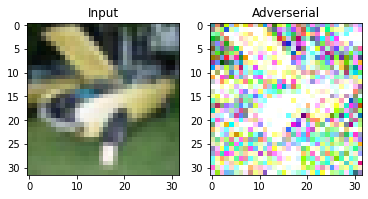

In [ ]:
input = plt.subplot(1,2, 1)
plt.imshow(test_images[-2])
input.set_title('Input')

advs = plt.subplot(1, 2, 2)
plt.imshow(adv_im[-2])
advs.set_title('Adverserial')

In [ ]:
adv_data = tf.data.Dataset.from_tensor_slices(
    (adv_im, test_labels.astype(np.int32))).batch(128)

model2.evaluate(adv_data)
model2.predict_classes(adv_data)

79/79 [==============================] - 3s 36ms/step - loss: 13.0897 - accuracy: 0.1038


array([2, 8, 0, ..., 1, 0, 0])